#### imprort libraries

In [4]:
import transformers 
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

#### plot the number of labels

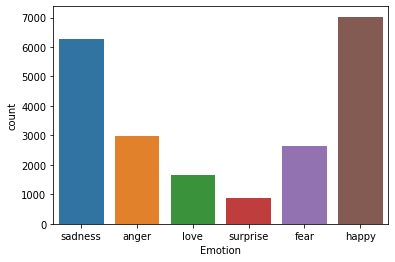

In [3]:
df = pd.read_csv("Emotion_final.csv")
sns.countplot(df.Emotion)

#### change the Emotion type to integer

In [5]:
label_encoder = LabelEncoder()
df["Emotion"] = label_encoder.fit_transform(df["Emotion"])
print(df)

                                                    Text  Emotion
0                                i didnt feel humiliated        4
1      i can go from feeling so hopeless to so damned...        4
2       im grabbing a minute to post i feel greedy wrong        0
3      i am ever feeling nostalgic about the fireplac...        3
4                                   i am feeling grouchy        0
...                                                  ...      ...
21454               Melissa stared at her friend in dism        1
21455  Successive state elections have seen the gover...        1
21456               Vincent was irritated but not dismay        1
21457  Kendall-Hume turned back to face the dismayed ...        1
21458                    I am dismayed , but not surpris        1

[21459 rows x 2 columns]


#### inutialization

In [4]:
print("SHAPE::",df.shape)

SHAPE:: (21459, 2)


In [5]:
class_name = ['sadness','anger','love','surprise','fear','happy']

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
device

device(type='cpu')

#### define model

In [8]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [9]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [86]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### count the lengh of tokens

100%|██████████████████████████████████████████████████████████████████████████| 21459/21459 [00:15<00:00, 1399.64it/s]


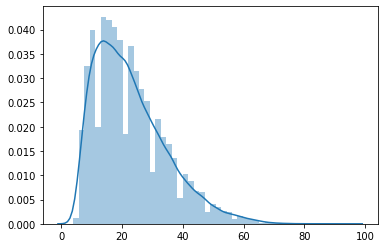

In [10]:
token_lens = []
for txt in tqdm(df.Text):
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
sns.distplot(token_lens)

#### loads data to a dictopnary

In [11]:
from torch.utils.data import Dataset, DataLoader
class TextDataset(Dataset):
    def __init__(self,texts,targets,tokenizer,max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self,item):
        text = str(self.texts[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            )
        
        return {
            'text_text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }

#### seprate train, validation and test data

In [14]:
size=len(df)
df_test = df[0:int(size/8)]
df_val = df[int(size/8):int(size/4)]
df_train = df[int(size/4):size]

In [15]:
df_train.shape, df_val.shape, df_test.shape


((16095, 2), (2682, 2), (2682, 2))

In [16]:
print(df)

                                                    Text  Emotion
0                                i didnt feel humiliated        4
1      i can go from feeling so hopeless to so damned...        4
2       im grabbing a minute to post i feel greedy wrong        0
3      i am ever feeling nostalgic about the fireplac...        3
4                                   i am feeling grouchy        0
...                                                  ...      ...
21454               Melissa stared at her friend in dism        1
21455  Successive state elections have seen the gover...        1
21456               Vincent was irritated but not dismay        1
21457  Kendall-Hume turned back to face the dismayed ...        1
21458                    I am dismayed , but not surpris        1

[21459 rows x 2 columns]


#### calculate the weight of each class

In [17]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df_train.Emotion.values),
                                                 df_train.Emotion.values)

In [18]:
class_weights

array([1.17550394, 1.32273176, 0.51586538, 2.21145919, 0.56917038,
       4.07056146])

#### data loader creation

In [19]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds = TextDataset(
        texts = df.Text.to_numpy(), 
        targets = df.Emotion.to_numpy(),
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(ds,
                      batch_size=batch_size,
                      num_workers=0)

In [20]:
MAX_LEN=10
BATCH_SIZE = 5
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

#### classifier
it shutdowns node by probablity of 0.4 before and after hidden layers, last layer cantains 6 nodes

In [21]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.4)
        #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.out1 = nn.Linear(self.bert.config.hidden_size, 128)
        self.drop1 = nn.Dropout(p=0.4)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #output = self.relu(pooled_output)
        output = self.drop(pooled_output)
        output = self.out1(output)
        output = self.relu(output)
        output = self.drop1(output)
        return self.out(output)

In [22]:
model = SentimentClassifier(len(class_name))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### initialize the the number of training 

In [23]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

C:\Users\Fatemeh\anaconda3\lib\site-packages\transformers\optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


#### a training phase which includes a forward and backpropagation

In [24]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    print(data_loader)
    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

#### comparing the prediction and true label

In [25]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

#### train 5 times and save the accuracy and loss in each epoch

In [26]:
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------


C:\Users\Fatemeh\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss 1.2144799585698351 accuracy 0.5500465983224604
Val   loss 5.749081129468353 accuracy 0.12005965697240865

Epoch 2/5
----------
Train loss 1.0286010208968728 accuracy 0.6497670083876981
Val   loss 3.6793912855606505 accuracy 0.2803877703206562

Epoch 3/5
----------
Train loss 0.9356297204463646 accuracy 0.6924510717614166
Val   loss 3.6829244465579314 accuracy 0.2121551081282625

Epoch 4/5
----------
Train loss 0.8188944488334747 accuracy 0.7244485865175521
Val   loss 2.1532502759376357 accuracy 0.5417598806860552

Epoch 5/5
----------
Train loss 0.7263720353362105 accuracy 0.7559490525007766
Val   loss 1.3385945179801455 accuracy 0.639821029082774



#### plot the accuracy and loss in each epoch

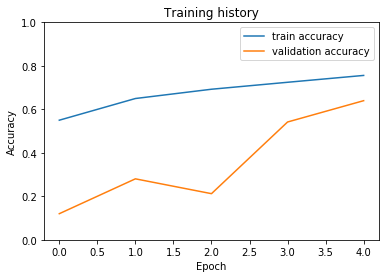

In [27]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

#### evaluate model with test data

In [28]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

C:\Users\Fatemeh\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0.6562266964951529

In [29]:
def get_predictions(model, data_loader):
    model = model.eval()
    text_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
    for d in data_loader:
        texts = d["text_text"]
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
         )
        _, preds = torch.max(outputs, dim=1)
        text_texts.extend(texts)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return text_texts, predictions, prediction_probs, real_values

In [30]:
y_text_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

#### showing the result

In [31]:
print(classification_report(y_test, y_pred, target_names=class_name))

              precision    recall  f1-score   support

     sadness       0.78      0.60      0.68       370
       anger       0.72      0.52      0.60       307
        love       0.67      0.73      0.70       933
    surprise       0.55      0.42      0.48       216
        fear       0.60      0.76      0.67       745
       happy       0.73      0.39      0.51       111

    accuracy                           0.66      2682
   macro avg       0.68      0.57      0.61      2682
weighted avg       0.67      0.66      0.65      2682



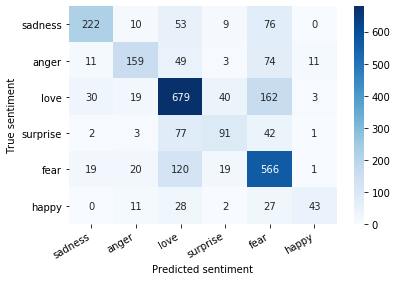

In [32]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

<div dir="rtl">
همانطور که در نمودار بالا نمایش داده شده، برچسب مربوط به عشق و ترس با دقت بالاتری پیش‌بینی شده است. در حالی که تعداد داده‌های مربوط به برچسب‌های غم و شادی بیشتر از بقیه بود و با توجه به عدم توازن داده‌ها  باید مدل با سمت آن‌ها متمایل می‌شد. این به علت حماسه ای است که من آفریدم! موقع تقسیم داده‌ها به داده‌های آموزش و اعتبارسنجی و تست، با فرض این که داده‌ها در هم ریخته است، داده‌ها را از ابتدا به سه بخش تقسیم کردم و قسمت اول را برای آموزش برداشتم و قسمت دوم را برای اعتبار سنجی و قسمت سوم را برای تست. اما در پایان فهمیدم که در این سه قسمت توزیع برچسب داده‌ها یکسان نیست. مثلا هنه‌ی غم‌ها در انتهای مجموعه داده آمده است :)
در گزارش در این مورد توضیح ندادم، چون اینجا بهتر می‌توانستم مشکل را نشان دهم.
</div>